In [72]:
# !pip install catboost
# !pip install ipywidgets
# !pip install sklearn
# !pip install git+https://github.com/clips/pattern@development#egg=pattern
# !pip install imblearn
# !pip install graphviz
# !pip install keras
# !pip install --user tensorflow


In [73]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import sklearn


sb.set() # set the default Seaborn style for graphics
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [74]:
# Import data
data = pd.read_csv("E:/6105/project/listings.csv")

# Data Preparation

We first prepare our data by identifying features with >60% null values. We do this to ensure that our followup data imputation on the features would not be skewed/ biased due to lack of data. For this case, only the feature "square_feet" was dropped.

We also identified the text features and stored them in nlp_list for later use. 

We then proceed to format the data in the following manner:
* Convert dates to datetime format
* Remove '\\$' and ',' from price features, then convert to float
* Convert percentage based features to float
* Convert true/false features to boolean format

Observe the data

In [75]:
# Check for null data
data.isna().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [76]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Deduplication

In [77]:
# Data De-duplication (using 'id' column)
data.drop_duplicates('id', 'first', inplace=True)

C:\Users\LOLA\AppData\Local\Temp\ipykernel_15980\1176806839.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop_duplicates except for the argument 'subset' will be keyword-only.



Lost value processing: delete more than 60% of na; delete important categorical variables without data; replace missing values of some numerical categories with mean values

In [78]:
# Drop data with >60% null values
null_list = ["square_feet"]
for feature in null_list:
    data = data.drop([feature], axis=1) 

# Drop rows without review data, mean/median imputaiton will skew the data tremendously since majority has high ratings
data = data[data['review_scores_rating'].notna()]

In [79]:
# Replace NA with attribute mean in some columns
data['accommodates'].fillna(data['accommodates'].mean())
data['host_listings_count'].fillna(data['host_listings_count'].mean())
data['host_total_listings_count'].fillna(data['host_total_listings_count'].mean())

0         3.0
1         6.0
2         2.0
4         2.0
5         1.0
        ...  
3810      1.0
3811      1.0
3812      3.0
3813    354.0
3814      1.0
Name: host_total_listings_count, Length: 3171, dtype: float64

Data type conversion: conversion of date data, processing of price signed units into floating point numbers; conversion of percentages into floating point numbers; Discretization and Binarization: conversion of binary variables into Boolean

In [80]:
# Convert to datetime
date_list = ["last_scraped", "host_since", "first_review", "last_review"]
for feature in date_list:
    data[feature] =  pd.to_datetime(data[feature])


In [81]:
# Convert dollars to float
price_list = ["price", "security_deposit", "cleaning_fee", "extra_people", "weekly_price", "monthly_price"]
for feature in price_list:
    data[feature] = data[feature].astype("str")
    data[feature] = data[feature].apply(lambda x: x.replace('$',''))
    data[feature] = data[feature].apply(lambda x: x.replace(',',''))
    data[feature] = data[feature].astype("float")


In [82]:
# Convert percentage to float
pct_list = ["host_response_rate", "host_acceptance_rate"]
for feature in pct_list:
    data[feature] = data[feature].astype("str")
    data[feature] = data[feature].apply(lambda x: x.replace('%',''))
    data[feature] = data[feature].astype("float")

In [83]:
# Convert boolean features
bool_list = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "is_location_exact", "has_availability"
             , "instant_bookable", "require_guest_profile_picture", "require_guest_phone_verification"]
for feature in bool_list:
    try:
        data[feature] = data[feature].astype("bool")
    except:
        continue

In [84]:
# Categorise calendar_updated feature
def cal_classify(row):
    month_placeholder = ("1","2","3","4")
    year_placeholder = ("1","2","3","4","5","6","7","8","9","10","11","12")
    if "today" in row:
        return "today"
    elif "yesterday" in row or "days" in row or " a week" in row:
        return "Within a Week"
    elif row.startswith(month_placeholder) and "weeks" in row:
        return "Within a Month"
    elif ((row.startswith(year_placeholder)) and "months" in row) or "weeks" in row:
        return "Within a Year"
    elif "months" in row:
        return "More than a Year"

data["*calendar_updated"] = data["calendar_updated"].apply(cal_classify)
data = data.drop(["calendar_updated"], axis=1)

# Data Processing
Within the data, there are certain features like "host_verifications" which are a list of strings, which are not readable by our machine learning model. This section of the notebook will focus on processing our features to be readable inputs.

* Convert "last_scraped" date to the number of months since last scraped
* One-hot encode "host_verifications" and "amenities" into a group of binary features
* Classify dates in "caendar_updated" into more generic categories

Feature Generation/Creation

In [85]:
# Parse datetime features, and calculate number of months from last_scraped
date_parse_list = ["host_since", "first_review", "last_review"]
for feature in date_parse_list:
        data['*'+feature] = np.ceil(((data["last_scraped"] - data[feature])/np.timedelta64(1, 'M')))
        
for feature in date_list:
    data = data.drop([feature], axis=1)
    

In [86]:
# Encode host_verifications into new features
def host_classify(row, feature):
    if str(feature) in row:
        val = 1
    else:
        val = 0
    return val

verification_list = ["email", "phone", "reviews", "kba", "facebook", "linkedin", "jumio", "google", "amex", "manual_offline"]
for feature in verification_list:
    data["*"+feature] = data["host_verifications"].apply(host_classify, feature=feature)
    data["*"+feature] = data["*"+feature].astype("bool")
data = data.drop(["host_verifications"], axis=1)

In [87]:
# Cleaning amenities feature
amenities_list = list(data.amenities)
amenities_list = " ".join(amenities_list)
amenities_cleaned = amenities_list.replace('{', '')
amenities_cleaned = amenities_cleaned.replace('}', ',')
amenities_cleaned = amenities_cleaned.replace('"', '')
amenities_set = [x.strip() for x in amenities_cleaned.split(',')]
amenities_set = set(amenities_set)
amenities_list = list(amenities_set)
amenities_list.remove('')


In [88]:
# Encode amnenities into new features
def amenities_classify(row, feature):
    if str(feature) in row:
        val = 1
    else:
        val = 0
    return val

for feature in amenities_list:
    data["*"+feature] = data["amenities"].apply(amenities_classify, feature=feature)
    data["*"+feature] = data["*"+feature].astype("bool")
data = data.drop(["amenities"], axis=1)

In [89]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 139 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    id                                int64  
 1    listing_url                       object 
 2    scrape_id                         int64  
 3    name                              object 
 4    summary                           object 
 5    space                             object 
 6    description                       object 
 7    experiences_offered               object 
 8    neighborhood_overview             object 
 9    notes                             object 
 10   transit                           object 
 11   thumbnail_url                     object 
 12   medium_url                        object 
 13   picture_url                       object 
 14   xl_picture_url                    object 
 15   host_id                           int64  
 16   host_url              

## Outliers

In [90]:
# Remove outlier
data = data[data.host_acceptance_rate > 0]

In [91]:
data.to_csv("data.csv", index=False)

# Exploratory Data Analysis


# Problem Formulation
We chose to tackle the dataset from a consumer's point of view, meaning how can we use the Airbnb dataset to benefit people seeking rental appartments as compared to the conventional "host-oriented" approach.

<Axes: xlabel='review_scores_rating', ylabel='Density'>

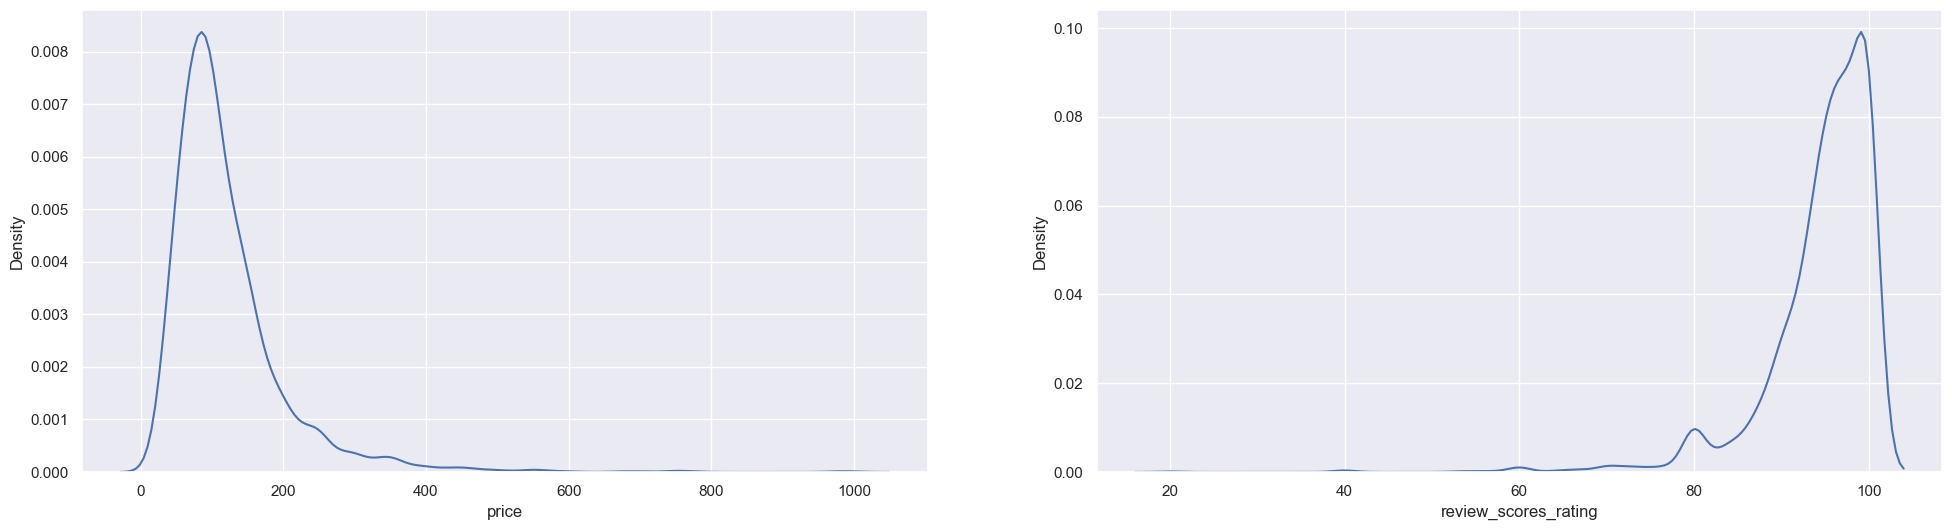

In [92]:
# Plot KDE of price and review ratings
f, axes = plt.subplots(1,2,figsize=(24,6))
sb.kdeplot(data["price"],ax=axes[0])
sb.kdeplot(data["review_scores_rating"],ax=axes[1])

# Approach
Intuitively, a low price with high reviews would make a listing worth. For this project, we assume that the concept of "worth" can be represented by a new feature:
# <center>Value = $\frac{review\_scores\_rating}{price}$<center>
    
We noted some interesting points by visualising our price and review_scores_rating data:
* Data points cluster around regions of high review ratings and low price
* Our new feature "value" is skewed towards lower values, suggesting some high-value outliers
* Log-transform of value indicated a normal distribution

We then partitioned the data according to value's percentiles:
* Value < 0.15 pctl : "Not Worth"
* < 0.20 pctl < Value < 0.80 pctl : "Worth"
* Value > 0.85 pctl : "Very Worth"

C:\Users\LOLA\AppData\Local\Temp\ipykernel_15980\957550144.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='value', ylabel='Density'>

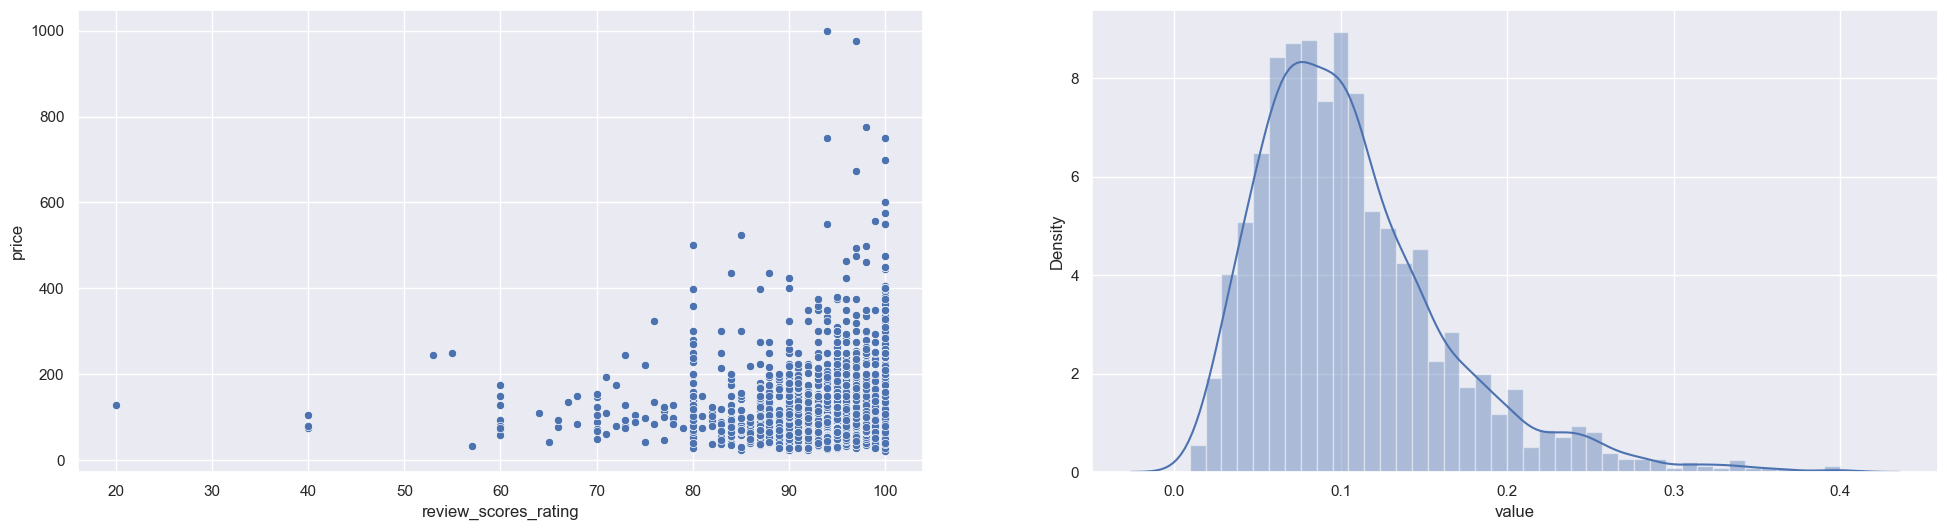

In [93]:
# Visualise price, review and engineered feature value
data["score"] =0.5*data["review_scores_value"]+0.2*data["review_scores_location"]+0.15*data["review_scores_accuracy"]+0.08*data["review_scores_cleanliness"]+0.04*data["review_scores_checkin"]+0.03*data["review_scores_communication"]
data["value"] = pd.to_numeric(data["score"])/pd.to_numeric(data["price"])
f, axes = plt.subplots(1,2,figsize=(24,6))
sb.scatterplot(x="review_scores_rating", y="price", data=data, ax=axes[0])
sb.distplot(data["value"].dropna(),ax=axes[1])



C:\Users\LOLA\AppData\Local\Temp\ipykernel_15980\3907073389.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='value', ylabel='Density'>

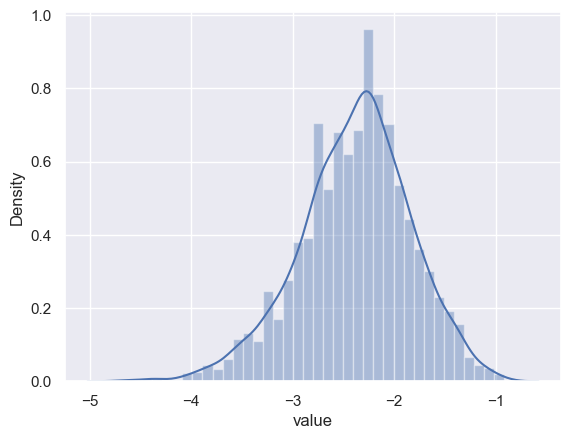

In [94]:
# Visualise log-transform feature "value"
sb.distplot(np.log(data["value"].dropna()))

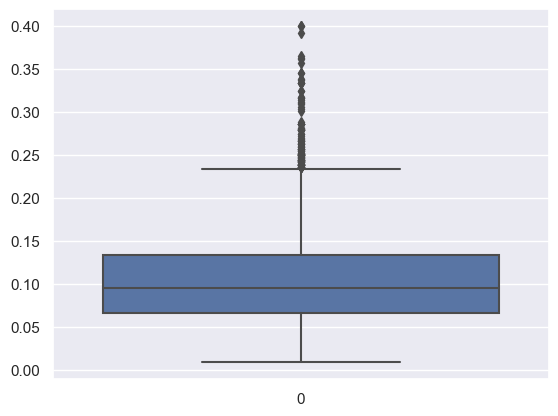

In [95]:
# Classify label categories
sb.boxplot(data["value"].dropna())
sd = np.std(data["value"].dropna())
upper_pctl = np.percentile(data["value"].dropna(), 80)
lower_pctl = np.percentile(data["value"].dropna(), 20)

def classify(row):
    if row["value"] < lower_pctl:
        val = "Not Worth"
    elif lower_pctl <= row["value"] <= upper_pctl:
        val = "Worth"
    else:
        val = "Very Worth"
    return val

data["data_label"] = data.apply(classify, axis=1)
data["data_label"] = pd.Categorical(data["data_label"], categories=['Not Worth', 'Worth', 'Very Worth'], ordered=True) 

<Axes: xlabel='data_label', ylabel='count'>

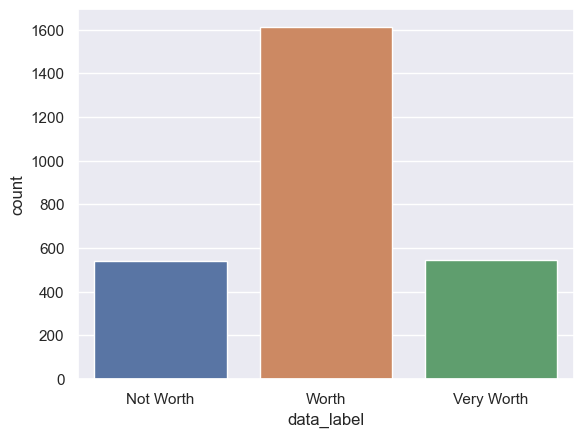

In [96]:
# Visualise "labels"
sb.countplot(x=data["data_label"])

# Dimensionality Reduction

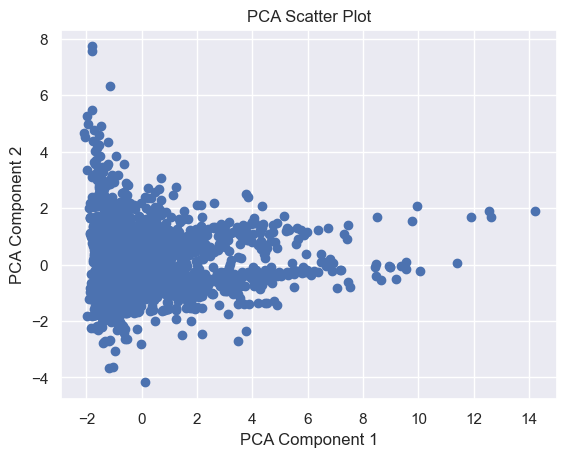

In [97]:
# Load the data
df = pd.read_csv("data.csv")

# Select the numerical columns
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']
df_num = df[numerical_cols]

# Impute missing values
df_num = df_num.fillna(df_num.median())

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Scatter Plot')
plt.show()

# Exploratory Data Analysis

## Score Analysis

In [98]:
import plotly.graph_objects as go

x_data = ["review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
                  "review_scores_location", "review_scores_value"]

y_data = [data["review_scores_accuracy"], data["review_scores_cleanliness"], data["review_scores_checkin"],
          data["review_scores_communication"], data["review_scores_location"], data["review_scores_value"]]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    title='Comparison of review scores',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()

## Listing Property Analysis

In [100]:
# Plot bi-variate distribution scatter matrix of amenities
import plotly.graph_objects as go
import pandas as pd
index_vals = data['data_label'].astype('category').cat.codes
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='*Heating',
                                 values=data["*Heating"]),
                            dict(label='*Carbon Monoxide Detector',
                                 values=data["*Carbon Monoxide Detector"]),
                           dict(label='*Gym',
                                 values=data["*Gym"]),
                           dict(label='*Internet',
                                 values=data["*Internet"]),
                           dict(label='*Air Conditioning',
                                 values=data["*Air Conditioning"]),
                            dict(label='beds',
                                 values=data["beds"]),
                            dict(label='*Indoor Fireplace',
                                 values=data["*Indoor Fireplace"]),
                            dict(label='*Smoke Detector',
                                 values=data["*Smoke Detector"]),
                            dict(label='*Pool',
                                 values=data["*Pool"]),
                            dict(label='price',
                                 values=data["price"]),
                           dict(label='value',
                                 values=data["value"])],
                text=data['data_label'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='white', line_width=0.5)
                ))


fig.update_layout(
    title='Listing Properties',
    dragmode='select',
    width=1200,
    height=1200,
    hovermode='closest',
)
fig.show()

# Feature Engineering
There are some features we believe by feature crossing, would be useful to our model. Feature crossing is the multiplication of 2 or more features to capture a joint relation.

## Continuous features
* host_response_rate x host_acceptance_rate: Represents host acceptance frequency
* number_of_reviews x host_listings_count: Gives weight to review frequency of host listing
* cleaning_fee x security_deposit: Represents a high fee charge
* reviews_per_month / number_of_reviews: Gives weights to recent listings and reviews

## Discrete features
* Kitchen x Hot Tub: Perhaps better overall facilities
* Kitchen x Gym: Perhaps better overall facilities
* Gym x Hot Tub: Perhaps better overall facilities
* Air Conditioning x Heating: Perhaps better overall facilities
* Pool x Hot Tub: Perhaps better overall facilities

In [101]:
# Add engineered features
data["*acceptance-response"] = data["host_response_rate"]*data["host_acceptance_rate"]
data["*review-freq"] = data["number_of_reviews"]*data["host_listings_count"]
data["*cleaning-deposit"] = data["cleaning_fee"]*data["security_deposit"]
data["*review_recency"] = data["reviews_per_month"]/data["number_of_reviews"]

data["*kitchen-tub"] = data["*Kitchen"]&data["*Hot Tub"]
data["*kitchen-gym"] = data["*Kitchen"]&data["*Gym"]
data["*gym-tub"] = data["*Gym"]&data["*Hot Tub"]
data["*ac-heat"] = data["*Air Conditioning"]&data["*Heating"]
data["*pool-tub"] = data["*Pool"]&data["*Hot Tub"]


In [102]:
# Drop irrelevant features
irrelevant_list = ["id", "experiences_offered", "listing_url", "scrape_id", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url"
                   , "host_id", "host_url", "host_name", "host_thumbnail_url", "host_picture_url", "market", "smart_location", 
                   "country_code", "country", "requires_license", "license", "jurisdiction_names", "calendar_last_scraped"]

uncleaned_neighbourhoods = ["neighbourhood", "neighbourhood_cleansed", "street", "zipcode", "host_location"]

rel_features = ["price", "value", "review_scores_rating", "weekly_price", "monthly_price"]

for feature in irrelevant_list:
    data = data.drop([feature], axis=1)
    
for feature in uncleaned_neighbourhoods:
    data = data.drop([feature], axis=1)
    
for feature in rel_features:
    data = data.drop([feature], axis=1)


In [103]:
# Save and drop nlp features to another dataframe
nlp_list = ["name", "summary", "space", "description", "neighborhood_overview" , "notes", "transit", "host_about", "state"]
nlp_df = pd.DataFrame()
for feature in nlp_list:
    nlp_df[feature] = data[feature]
    data = data.drop([feature], axis=1)

In [104]:
data.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,*host_since,*first_review,*last_review,score,*acceptance-response,*review-freq,*cleaning-deposit,*review_recency
count,2677.000000,2693.0,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2681.000000,2687.000000,2693.000000,1381.000000,2068.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2688.000000,2692.000000,2688.000000,2692.000000,2688.000000,2688.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2688.000000,2677.000000,2693.000000,1247.000000,2693.000000
mean,95.338439,100.0,7.953212,7.953212,47.628000,-122.332679,3.387672,1.248601,1.273167,1.743038,270.453295,60.038201,1.711474,11.195321,2.364278,723.329744,17.781285,39.302636,62.129967,253.095433,29.480876,9.639509,9.569465,9.780878,9.802377,9.615699,9.461310,3.319346,2.313676,29.550316,14.002599,2.464166,9.550651,9533.843855,127.838470,23567.611868,0.204876
std,10.883151,0.0,27.590619,27.590619,0.042522,0.031428,1.996028,0.588939,0.855427,1.159972,229.034821,47.837776,1.307030,17.370442,19.324722,511.961468,11.278558,21.287761,30.661216,120.722350,42.102782,0.692263,0.767224,0.607587,0.584980,0.619740,0.734593,6.404208,1.861954,18.754617,13.617015,2.965615,0.556684,1088.315051,360.596336,50817.862342,0.241015
min,17.000000,100.0,1.000000,1.000000,47.507284,-122.417219,1.000000,0.000000,0.000000,1.000000,95.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.030000,1.000000,1.000000,1.000000,2.960000,1700.000000,1.000000,475.000000,0.012692
25%,98.000000,100.0,1.000000,1.000000,47.608176,-122.353064,2.000000,1.000000,1.000000,1.000000,125.000000,25.000000,1.000000,0.000000,1.000000,33.000000,7.000000,26.000000,45.000000,148.000000,5.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.890000,14.000000,5.000000,1.000000,9.270000,9800.000000,10.000000,5000.000000,0.054000
50%,100.000000,100.0,2.000000,2.000000,47.622337,-122.329277,3.000000,1.000000,1.000000,1.000000,200.000000,50.000000,1.000000,5.000000,2.000000,1125.000000,21.000000,48.000000,75.000000,318.000000,15.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.860000,27.000000,8.000000,2.000000,9.770000,10000.000000,31.000000,12000.000000,0.128571
75%,100.000000,100.0,3.000000,3.000000,47.661485,-122.310548,4.000000,1.000000,2.000000,2.000000,300.000000,80.000000,2.000000,20.000000,2.000000,1125.000000,29.000000,58.000000,88.000000,358.000000,36.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.260000,42.000000,19.000000,3.000000,10.000000,10000.000000,93.000000,23750.000000,0.234324
max,100.000000,100.0,502.000000,502.000000,47.733358,-122.254189,16.000000,8.000000,7.000000,15.000000,2500.000000,300.000000,13.000000,300.000000,1000.000000,1825.000000,30.000000,60.000000,90.000000,365.000000,474.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000,86.000000,78.000000,52.000000,10.000000,10000.000000,4563.000000,750000.000000,1.000000


In [105]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2693 entries, 0 to 3814
Data columns (total 111 columns):
 #    Column                            Dtype   
---   ------                            -----   
 0    host_response_time                object  
 1    host_response_rate                float64 
 2    host_acceptance_rate              float64 
 3    host_is_superhost                 bool    
 4    host_neighbourhood                object  
 5    host_listings_count               float64 
 6    host_total_listings_count         float64 
 7    host_has_profile_pic              bool    
 8    host_identity_verified            bool    
 9    neighbourhood_group_cleansed      object  
 10   city                              object  
 11   latitude                          float64 
 12   longitude                         float64 
 13   is_location_exact                 bool    
 14   property_type                     object  
 15   room_type                         object  
 16   acco

In [106]:
#Duplicating for data imputing.
dup_data = data.copy()

In [107]:
# Impute missing cat values as -999, Catboost will handle the heavylifting for both numerical and categorical features
cat_list = ["host_response_time", "host_neighbourhood", "neighbourhood_group_cleansed", "city", "property_type"
            , "room_type", "bed_type", "cancellation_policy", "*calendar_updated", "*kitchen-tub", "*kitchen-gym"
           , "*gym-tub", "*ac-heat", "*pool-tub"]
num_list = ["host_response_rate", "host_acceptance_rate", "host_listings_count", "host_total_listings_count", "bathrooms"
            , "bedrooms", "beds", "security_deposit", "cleaning_fee", "review_scores_accuracy"
            , "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication"
           , "review_scores_location", "review_scores_value", "reviews_per_month", "*host_since", "*first_review"
            , "*last_review", "*acceptance-response", "*review-freq", "*cleaning-deposit", "*review_recency"]

nlp_list = ["name", "summary", "space", "description", "neighborhood_overview" , "notes", "transit", "host_about", "state"]
for feature in cat_list:
    data[feature] = data[feature].astype('category')
    data[feature] = data[feature].cat.add_categories(-999).fillna(-999)

In [108]:
#data imputation for models without catboost
dup_data["host_neighbourhood"] = dup_data["host_neighbourhood"].fillna("Other")
dup_data["*calendar_updated"] = dup_data["*calendar_updated"].fillna("None")
#Clean bed_type to binary real bed or other
def recode(value):
    if value not in ['Real Bed']:
        return 'Other'
    return value

dup_data['bed_type'] = dup_data['bed_type'].apply(recode)
for feature in cat_list:
    dup_data[feature] = dup_data[feature].astype('category')
for feature in num_list:
    dup_data[feature] = dup_data[feature].fillna(dup_data[feature].median())

# Assumption and biases
Before we embark on the execution of our actual project, we should identify all the inherent biases and assumptions present within our approach.

Assumptions:
* The concept of value can be assessed by considering only price and review ratings
* The distribution from the dataset is representative of the population
* Catboost guarantees that a split that separates missing values from all other values is considered when selecting trees.

Biases:
* Certain features like room types and fees may drive prices up
* Certain neighbourhoods may have higher natural prices


# Model Selection

## Model 1: Classification Decision Tree Model

In [109]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz

# duplicate df for #1 Decision Tree Model
tree_df = dup_data

In [110]:
# Get 'category' types and stores in list
cat_df = tree_df.select_dtypes('category')
category_list = list(cat_df)

In [111]:
# Get 'boolean' types and stores in list
bool_df = tree_df.select_dtypes('bool')
bool_list = list(bool_df)

In [112]:
# Extract Response(y) and Predictors(x)
decisiontree_y = tree_df["data_label"]
decisiontree_X = tree_df.drop("data_label",axis = 1)

In [113]:
#One hot encoding for all categorical features
category_list.remove('data_label')
decisiontree_X = pd.get_dummies(decisiontree_X, columns=category_list)

In [114]:
# Convert boolean features to 0 or 1  
for feature in bool_list:
    try:
        decisiontree_X[feature] = decisiontree_X[feature].astype("int")
    except:
        continue

In [115]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(decisiontree_X, decisiontree_y, test_size = 0.2)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6689879294336118

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.686456400742115



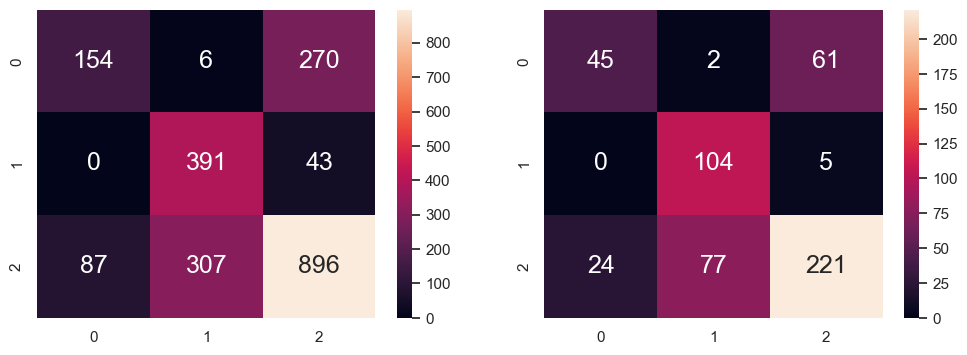

In [137]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 2)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()



# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

In [138]:
# Get the classification report (F1-Score)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

   Not Worth       0.65      0.42      0.51       108
  Very Worth       0.57      0.95      0.71       109
       Worth       0.77      0.69      0.73       322

    accuracy                           0.69       539
   macro avg       0.66      0.69      0.65       539
weighted avg       0.71      0.69      0.68       539



## Model 2: Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

In [120]:
reg_model_data = pd.DataFrame(dup_data[["host_neighbourhood", "neighbourhood_group_cleansed", "property_type","room_type", "bed_type", "cancellation_policy", "*kitchen-tub", "*kitchen-gym"
           , "*gym-tub", "*ac-heat", "*pool-tub", "*acceptance-response", "*review-freq", "*cleaning-deposit", "*review_recency", "data_label"]])
reg_model_data = pd.get_dummies(reg_model_data, columns=["host_neighbourhood","neighbourhood_group_cleansed", "property_type", "room_type", "bed_type", "cancellation_policy", "*kitchen-tub", "*kitchen-gym"
           , "*gym-tub", "*ac-heat", "*pool-tub" ])
y = reg_model_data["data_label"]
X = reg_model_data.drop(["data_label"], axis=1)
weights = {"Not Worth": 1.8093410108765196, "Worth": 1.6031746031746033, "Very Worth": 0.5483808415745588}

In [121]:
correlated_features = set()
correlation_matrix = reg_model_data.drop('data_label', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [122]:
scaler = StandardScaler()
X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=1234)
logReg = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter = 2828,multi_class="multinomial")
logReg.fit(X_train, y_train)

LogisticRegression(class_weight={'Not Worth': 1.8093410108765196,
                                 'Very Worth': 0.5483808415745588,
                                 'Worth': 1.6031746031746033},
                   max_iter=2828, multi_class='multinomial')

In [123]:
predition1 = logReg.predict(X_test)
score1 = logReg.score(X_test,y_test)
print("the accuracy of the model is ",score1)

the accuracy of the model is  0.7217068645640075


In [124]:
rfecv = RFECV(estimator=logReg, step=1, cv=StratifiedKFold(10), scoring='f1_macro')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(class_weight={'Not Worth': 1.8093410108765196,
                                                 'Very Worth': 0.5483808415745588,
                                                 'Worth': 1.6031746031746033},
                                   max_iter=2828, multi_class='multinomial'),
      scoring='f1_macro')

In [125]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 13


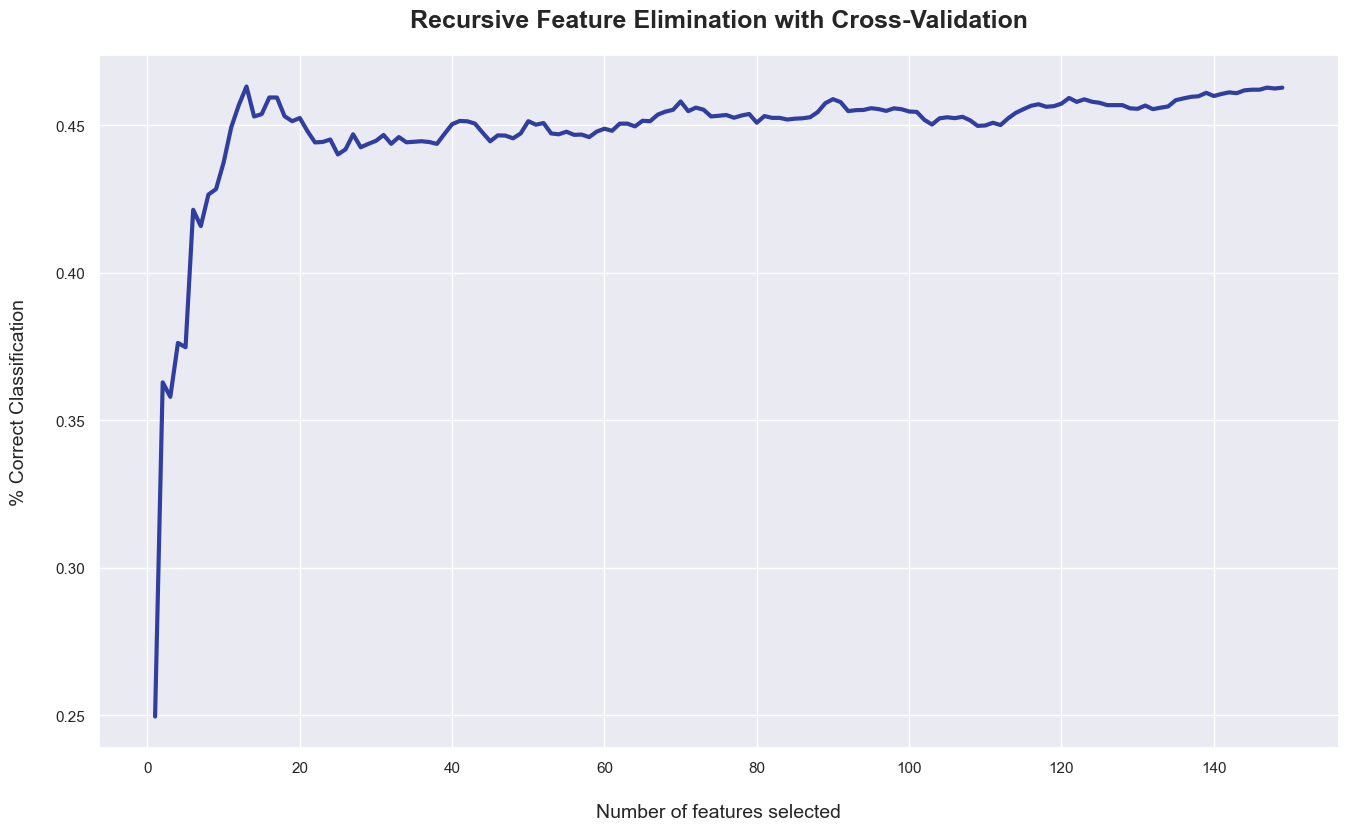

In [126]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
plt.show()

In [127]:
#dropping features
print(np.where(rfecv.support_ == False)[0])
X_cleansed = np.delete(X, np.where(rfecv.support_ == False)[0] , axis = 1)

[  0   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 101 102 105 106 107 108 109 111 112 113 114 115
 116 117 118 119 120 121 122 123 125 126 127 128 129 130 134 136 137 138
 139 140 141 142 143 144 145 146 147 148]


In [128]:
# Split train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cleansed, y, train_size=0.8, random_state=1234)
logRegv2 = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter = 2828,multi_class="multinomial")
logRegv2.fit(X_train, y_train)

LogisticRegression(class_weight={'Not Worth': 1.8093410108765196,
                                 'Very Worth': 0.5483808415745588,
                                 'Worth': 1.6031746031746033},
                   max_iter=2828, multi_class='multinomial')

In [129]:
prediction = logRegv2.predict(X_test)
score = logRegv2.score(X_test,y_test)
print("the accuracy of the model is ",score)
print("////////////////////////////////////////////////////////////")
print(classification_report(y_test, prediction))

the accuracy of the model is  0.7087198515769945
////////////////////////////////////////////////////////////
              precision    recall  f1-score   support

   Not Worth       0.68      0.38      0.49       108
  Very Worth       0.86      0.32      0.47        97
       Worth       0.70      0.93      0.80       334

    accuracy                           0.71       539
   macro avg       0.75      0.54      0.58       539
weighted avg       0.73      0.71      0.68       539



## Model 3: k-Nearest-Neighbors Model

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [131]:
KNNy = reg_model_data["data_label"]
KNNX = reg_model_data.drop(["data_label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(KNNX,KNNy,train_size=0.8, random_state=1234,stratify=y)


In [132]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [133]:
knn.score(X_test, y_test)

0.5844155844155844

In [134]:
#k-Fold Cross-Validation
knn_cv = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(knn_cv, KNNX, KNNy, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
#mean >  more accurate representation of how our model will perform on unseen data.


[0.60111317 0.57513915 0.58998145 0.59851301 0.60037175]
cv_scores mean:0.5930237049196158


In [135]:
#Hypertuning model parameters using GridSearchCV
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(KNNX, KNNy)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [136]:
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

{'n_neighbors': 15}
0.6461125173286617


In [115]:
prediction = knn_gscv.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

   Not Worth       0.62      0.45      0.52       108
  Very Worth       0.63      0.25      0.36       109
       Worth       0.67      0.87      0.76       322

    accuracy                           0.66       539
   macro avg       0.64      0.52      0.55       539
weighted avg       0.65      0.66      0.63       539



## Model 4: Catboost Model

In [125]:
# Create X and y
df = pd.DataFrame()
df = data
y = data["data_label"]
X = data.drop(["data_label"], axis=1)
cat_features = cat_list


In [126]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234)

model = CatBoostClassifier(
    iterations=1000,
    random_seed=1234,
    learning_rate=0.1,
    bootstrap_type='Bayesian',
    loss_function='MultiClass',
    custom_loss=['F1'],
    early_stopping_rounds=10,
    use_best_model=True,
    task_type='GPU',
)

#Fit model
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

NameError: name 'CatBoostClassifier' is not defined

In [70]:
# Helper function for scoring
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-MultiClass-mean'].min()
    best_iter = cv_data['test-MultiClass-mean'].values.argmin()

    print('Best validation MultiClass score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-MultiClass-std'][best_iter],
        best_iter)
    )

In [71]:
# Check cv score on first model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234)

train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features,
    feature_names=list(X_train)
)

test_pool = Pool(
    X_test, 
    y_test, 
    cat_features=cat_features,
    feature_names=list(X_train)
)
from catboost import cv
cv_data_0 = cv(
    params = model.get_params(),
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=1234,
    plot=True,
    stratified=True,
    verbose=False
)

print_cv_summary(cv_data_0)
from catboost.utils import get_confusion_matrix
cm = get_confusion_matrix(model, test_pool)
print(cm)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best validation MultiClass score : 0.4439±0.0338 on step 232
[[ 64.   0.  28.]
 [  0.  93.  34.]
 [ 20.  25. 270.]]


In [72]:
prediction = model.predict(test_pool)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

   Not Worth       0.76      0.70      0.73        92
  Very Worth       0.79      0.73      0.76       127
       Worth       0.81      0.86      0.83       315

    accuracy                           0.80       534
   macro avg       0.79      0.76      0.77       534
weighted avg       0.80      0.80      0.80       534



In [73]:
# Evaluate catboost model score
metrics = model.eval_metrics(
    data=test_pool,
    metrics=['F1'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Model Evaluation
Visually, we see that catboost outperforms all models in every category. Hence we will focus on deriving data intuition through catboost results.

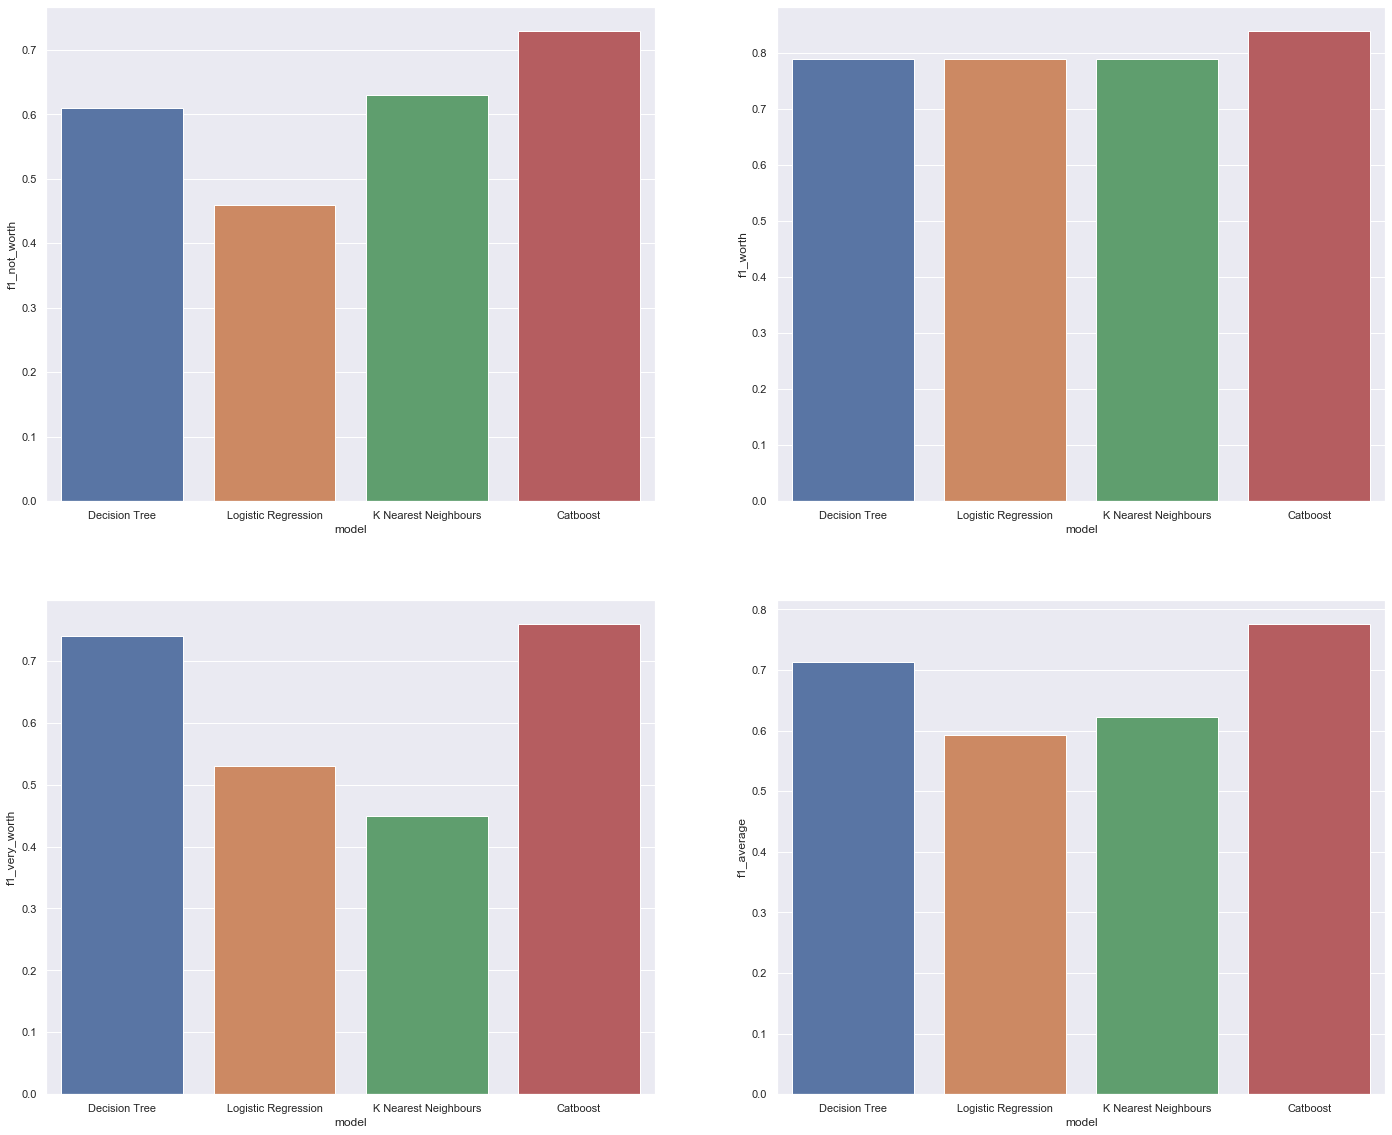

In [74]:
import seaborn as sb
f1_plot = pd.DataFrame()
f1_plot["model"] = ["Decision Tree", "Logistic Regression", "K Nearest Neighbours", "Catboost"]
f1_plot["f1_not_worth"] = [0.61,0.46,0.63,0.73]
f1_plot["f1_worth"] = [0.79,0.79,0.79,0.84]
f1_plot["f1_very_worth"] = [0.74,0.53,0.45,0.76]
f1_plot["f1_average"] = (f1_plot["f1_not_worth"] + f1_plot["f1_worth"] + f1_plot["f1_very_worth"])/3

f, axes = plt.subplots(2, 2, figsize=(24, 20))
sb.barplot(x="model", y="f1_not_worth", data=f1_plot,ax=axes[0,0])
sb.barplot(x="model", y="f1_worth", data=f1_plot,ax=axes[0,1])
sb.barplot(x="model", y="f1_very_worth", data=f1_plot,ax=axes[1,0])
sb.barplot(x="model", y="f1_average", data=f1_plot,ax=axes[1,1])
